# Convolutional Neural Network
### Wang Ning-Ya 103062118

In [10]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pylab as plt
import time

In [16]:
class FC_Layer(object):
    '''Fully-Connected Layer'''
    
    def __init__(self, Layers=(2, 5, 3), BatchSize = 4):
        self.bs = BatchSize
        #for building multiple layer of fully-connected
        self.net = [dict() for i in range(len(Layers))]
        
        #first layer of fully connected is simply the output of Convolution layer
        self.net[0]['a'] = np.zeros((Layers[0], self.bs))
        self.net[0]['dJda'] = np.zeros((Layers[0], self.bs))
        
        #build layer according to input specification
        for i in range(1, len(Layers)):
            self.net[i]['a'] = np.zeros( (Layers[i], self.bs) )
            self.net[i]['z'] = np.zeros( (Layers[i], self.bs) )
            self.net[i]['W'] = np.random.randn(Layers[i], Layers[i-1])
            self.net[i]['b'] = np.random.randn(Layers[i], 1)
            self.net[i]['dJda'] = np.zeros((Layers[i], self.bs))
            self.net[i]['dJdz'] = np.zeros((Layers[i], self.bs))
            self.net[i]['dJdW'] = np.zeros((Layers[i], Layers[i-1]))
            self.net[i]['dJdb'] = np.zeros((Layers[i], 1))
        
        self.p = np.zeros( self.net[-1]['a'].shape) # Softmax Output
        self.yhat = np.zeros(self.bs, dtype=int) # Predicted Answer
        self.y_onehot = np.zeros(self.p.shape, dtype=int) #output in one-hot format
        self.J = [] # Loss value trace
        self.ValidJ = [] #loss of validation
        self.Accu = [] #Accuracy trace
        self.VAccu = [] # accuracy of validation
        
    #change number to 0~1, and sum = 1
    def softmax(self, a):
        aa =a - np.max(a) # minus max for preventing overflow
        return np.exp(aa) / np.sum(np.exp(aa), axis = 0)
    
    def LeakyReLU(self, z, leakyrate=0.01):
        a = np.zeros(z.shape)
        (rows, cols) = a.shape
        for i in range(rows):
            for j in range(cols):
                a[i, j] = z[i, j] if z[i,j] > 0 else (leakyrate * z[i, j])
        return a
    
    def LeakyReLUPrime(self, a, leakyrate = 0.01):
        dadz = np.zeros(a.shape)
        (rows, cols) = a.shape
        for i in range(rows):
            for j in range(cols):
                #here we return only ratio since we multiply dJda outside
                dadz[i, j] = 1.0 if a[i,j] > 0 else  leakyrate
        return dadz
    
    def forward(self, x):
        np.copyto(self.net[0]['a'], x)
        
        for i in range(1, len(self.net)):
            #I don't really understand why we take average of W*a, 
            #but otherwise it's likely for getting a value that's way too big
            np.copyto(self.net[i]['z'],
                      np.dot(self.net[i]['W'], self.net[i-1]['a']) / self.net[i-1]['a'].shape[0]
                      + self.net[i]['b'])
            np.copyto(self.net[i]['a'], self.LeakyReLU(self.net[i]['z'], 0.01))
        
        np.copyto(self.p, self.softmax(self.net[-1]['a']))
        #after softmax, we'll have a pobability, for each number in 0~9, 
        #and we pick the one with highest pobability as our answer
        np.copyto(self.yhat, np.argmax(self.p, axis=0))

        return
    
    def loss(self, y):
        self.y_onehot.fill(0)
        #mark the answer as 1 and left the rest 0
        for i in range(self.bs):
            self.y_onehot[y[i], i] = 1
        
        J = 0.0
        for i in range(10):
            #modified a bit here, to prevent np.log(0), which will cause NaN value occur
            for j in range(self.bs):
                if( self.p[i , j] <= 0.0e+0 ):
                    J += self.y_onehot[i , j] * (-10000.0) 
                else:
                    J += self.y_onehot[i , j] * np.log( self.p[i, j] ) 
        self.J.append(-1.0* (J / self.bs) )
            
        return
            
    def backprop(self):
        #self.p is the probability that model predicted, y_onehot is ground truth, 
        #hence self.p - y_onehot is the error, witch is the gradient we will pass down
        np.copyto(self.net[-1]['dJda'], self.p - self.y_onehot )

        for i in range(len(self.net)-1, 0, -1):
            #get ratio from LeakyReLUPrime and multiply with dJda here
            np.copyto(self.net[i]['dJdz'], self.net[i]['dJda'] *self.LeakyReLUPrime(self.net[i]['a'], 0.01))
            np.copyto(self.net[i]['dJdb'],
                      np.mean(self.net[i]['dJdz'], axis = 1)[:, None])
            np.copyto(self.net[i]['dJdW'],
                      np.dot(self.net[i]['dJdz'], self.net[i-1]['a'].T)/self.bs)
            np.copyto(self.net[i-1]['dJda'],
                      np.dot(self.net[i]['dJdz'].T, self.net[i]['W']).T)
        return
            
    def update(self, lr=0.01):
        
        for i in range(1, len(self.net)):
            self.net[i]['W'] -= lr*self.net[i]['dJdW']
            self.net[i]['b'] -= lr*self.net[i]['dJdb']
        return
    
    #Accuray = number of correctness / number of sample
    def accuracy(self, y, accu, e):
        right = 0
        #count how many correctness
        for i in range(len(self.yhat)):
            if( self.yhat[i] == y[i] ):
                right += 1
        if( len(accu) <= e):
            accu.append(0)
        #since batch_size = 200, to get accuracy overall, I add up accuracy of each batch, then get average
        accu[e] += ( right / len(y) )
        return
    
    #To compute loss for validation, seperate from original one since I make it save loss value in another list
    #and get average loss of whole validation
    #everything else is same as original loss method
    def validation_loss(self, y, e):
        self.y_onehot.fill(0)
        for i in range(self.bs):
            self.y_onehot[y[i], i] = 1
        
        if( len(self.ValidJ) <= e ):
            self.ValidJ.append(0)
        
        J = 0.0
        for i in range(10):
            for j in range(self.bs):
                if( self.p[i , j] <= 0.0e+0 ):
                    J += self.y_onehot[i , j] * (-10000.0) 
                else:
                    J += self.y_onehot[i , j] * np.log( self.p[i, j] ) 
        self.ValidJ[e] += (-1.0* (J / self.bs) )
            
        return

In [17]:
class Conv_Layer(object):

    def __init__(self,
               bs,              #batch size
               i_ch,            #input chanel
               i_h,              #input height
               i_w,             #input weight
               k_num,        #number of kernel  (kernel = filter)
               k_h,             #kernal height
               k_w,             #kernel weight
               stride = 1,     #stride (how much to move when sliding window)
               zp = 0,         #zero-padding
               mph = 2,     #max_pooling height
               mpw = 2,     #max_pooling weight
               leakyrate = 0.01):
        
        self.bs = bs
        self.i_ch = i_ch
        self.i_h = i_h
        self.i_w = i_w
        self.k_num = k_num
        self.k_h = k_h
        self.k_w = k_w
        self.stride = stride
        self.zp = zp
        self.mph = mph
        self.mpw = mpw
        self.leakyrate = leakyrate
       
        self.ai = np.zeros((bs, i_ch, i_h+2*zp, i_w+2*zp))    #orginal input, in batch, add zp here for convenient 
        self.W = np.random.randn(k_num, i_ch, k_h, k_w) #every weight, kernel_num * (chanel*height*weight)
        self.b = np.random.randn(k_num, 1)                    #every bias, one for each kernel
        self.z = np.zeros((bs, k_num, (i_h - k_h+1)//stride, (i_w - k_w+1)//stride)) #after convolution, in batch
                                                                                                                    
        self.r = np.zeros(self.z.shape) #after relu/sigmoid 
        self.mp_trace = np.zeros(self.r.shape) 
        self.ao = np.zeros((bs, k_num, (i_h - k_h+1)//stride//mph, (i_w - k_w+1)//stride//mpw)) #final output after pooling
        
        #ai  -> z -> r -> ao
        
        #for BackPropagation
        self.dJdai = np.zeros(self.ai.shape)
        self.dJdW = np.zeros(self.W.shape)
        self.dJdb = np.zeros(self.b.shape)
        self.dJdz = np.zeros(self.z.shape)
        self.dJdr = np.zeros(self.r.shape)
        self.dJdao = np.zeros(self.ao.shape)

    def conv2d(self, i_tensor):
        (i_bs, i_ch, i_rows, i_cols) = i_tensor.shape  #i_tensor = input
        (k_num, k_ch, k_rows, k_cols) = self.W.shape
        self.ai.fill(0.0) 
        #copy input to proper position (avoid zp in front and back )
        np.copyto(self.ai[:, :, self.zp:self.zp+i_rows, self.zp:self.zp+i_cols], i_tensor)
        (z_bs, z_ch, z_rows, z_cols) = self.z.shape   # z_ch == k_num 
        for b in range(z_bs):                # for each batch
            for k in range(k_num):         # for each kernel
                #get the kernel
                kernel = self.W[k, :,  :, :]
                for r in range(z_rows):     #slide window from top to buttom (of origin image)
                    for c in range(z_cols): #slide window from right to left (of origin image)
                        #the input of current window (sub-image)  
                        img =  self.ai[b, :,
                                       r*self.stride : r*self.stride+k_rows,
                                       c*self.stride : c*self.stride+k_cols]
                        #output  = input*kernel + bias
                        self.z[b, k, r, c] = np.sum(img * kernel) + self.b[k]
        return 
  
    def conv2d_prime(self): 
        (z_bs, z_knum, z_rows, z_cols) = self.dJdz.shape
        (a_bs, a_ch, a_rows, a_cols) = self.dJdai.shape
        (k_num, k_ch, k_rows, k_cols) = self.dJdW.shape
        (b_num, b_ch) = self.dJdb.shape
        stride = 1 # self.stride
        self.dJdai.fill(0.0)
        self.dJdW.fill(0.0)
        
        #for each sample, to proudce a input_height * input_width output, 
        #we need a input(z) of z_height+(kernel_height -1) *2, multiple 2 because we got top and buttom of input to add
        #and same for width
        zp_dJdz = np.zeros((z_bs, z_knum, z_rows+2*(k_rows-1), z_cols+2*(k_cols-1)))
        #initial input, copy data to desired position as we did in conv2d
        np.copyto(zp_dJdz[:, :, k_rows-1:z_rows+k_rows-1, k_cols-1:z_cols+k_cols-1], self.dJdz)
        
        #rotated each kernel in advanced for convenient 
        rotated_W = np.zeros(self.W.shape)
        for k in range(k_num):
            for kch in range(k_ch):
                rotated_W[k, kch, :, :] = np.rot90(self.W[k, kch, :, :], 2)
                
        #do convolution on expanded dJdZ and rotated kernel, will get dJdai 
        for b in range(a_bs):
            for ch in range(a_ch):
                for r in range(a_rows):
                    for c in range(a_cols):
                        for k in range(k_num):
                            self.dJdai[b, ch, r, c] += np.sum(rotated_W[k, ch, :, :] * 
                                                              zp_dJdz[b, k, r:r+k_rows, c:c+k_cols])
        
        #sum up all gradient of each index of same kernel then update
        for k in range(k_num):
            for kch in range(k_ch):
                for kr in range(k_rows):
                    for kc in range(k_cols):
                        self.dJdW[k, kch, kr, kc] = np.mean(self.ai[:, kch,
                                                                   kr:a_rows-k_rows+1+kr,
                                                                   kc:a_cols-k_cols+1+kc]
                                                               * self.dJdz[:, k, :, :])
        
        for k in range(z_knum):
            self.dJdb[k] = np.mean(self.dJdz[:, k, :, :])
        
        return 
        

    def LeakyReLU(self):
        np.copyto(self.r, np.where(self.z > 0, 1.0 * self.z, self.leakyrate * self.z))
        return
    
    def LeakyReLU_prime(self):
        #gradients only go to where z > 0 (where affacted the result)
        np.copyto(self.dJdz, np.where(self.z > 0, 
                                      1.0 * self.dJdr,  self.dJdr * self.leakyrate ))
        return
            
    def max_pool(self):
        #input : data after relu/sigmoid 
        (r_bs, r_ch, r_rows, r_cols) = self.r.shape
        #output
        (a_bs, a_ch, a_rows, a_cols) = self.ao.shape
        self.mp_trace.fill(0)
        for b in range(a_bs):
            for ch in range(a_ch):
                for r in range(a_rows):
                    for c in range(a_cols):
                        #sub input of current window (window size = mph*mpw)
                        pool_src2d = self.r[b,
                                            ch,
                                            r*self.mph:(r+1)*self.mph,
                                            c*self.mpw:(c+1)*self.mpw] 
                        #max pooling
                        self.ao[b, ch, r, c] = np.max(pool_src2d)
                        #max_pos = position of max value
                        max_pos = np.unravel_index(np.argmax(pool_src2d), 
                                                   np.shape(pool_src2d))
                        #mark the position of max value as 1
                        self.mp_trace[b, ch, r*self.mph+max_pos[0], c*self.mpw+max_pos[1]] = 1.0
        return
    
    #in backprop of max pooling:
    #gradient from the next layer is passed back to ONLY that neuron which achieved the max.
    #All other neurons get zero gradient
    def max_pool_prime(self):
        (r_bs, r_ch, r_rows, r_cols) = self.dJdr.shape
        for b in range(r_bs):
            for ch in range(r_ch):
                for r in range(r_rows):
                    for c in range(r_cols):
                        #recall each window and record gradients
                        self.dJdr[b, ch, r, c] = (self.dJdao[b, ch, r//self.mph, c//self.mpw]
                                                  if self.mp_trace[b, ch, r, c] == 1.0
                                                  else 0.0)                       
        return
    
    def forward(self, input_tensor):
        self.conv2d(input_tensor)
        self.LeakyReLU()
        self.max_pool()
        return
    
    def backprop(self):
        #note that dJdao isn't compute nowhere in this class, but in class CNN
        self.max_pool_prime()
        self.LeakyReLU_prime()
        self.conv2d_prime()
        return
    
    def update(self, lr=0.1): #Ir = learning rate
        self.W -= lr * self.dJdW
        self.b -= lr * self.dJdb
        return
    
   

In [93]:
class CNN(object):
    def __init__(self,
                #inpute_data_dpec = [batch_size, chanel, height, weight]
                input_data_spec = [10, 3, 28, 28],
                conv_layer_spec = [{"k_num" : 2, "k_h" : 3,  "k_w" : 3, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}],
                fc_layer_spec = [100, 50, 10]):
        self.c_net = []
        #build  Convolution layers according to input specification
        for i in range(len(conv_layer_spec)):
            self.c_net.append(Conv_Layer(bs = input_data_spec[0],
                                  i_ch = input_data_spec[1],
                                  i_h = input_data_spec[2],
                                  i_w = input_data_spec[3],
                                  k_num = conv_layer_spec[i]['k_num'],
                                  k_h = conv_layer_spec[i]['k_h'],
                                  k_w = conv_layer_spec[i]['k_w'],
                                  stride = conv_layer_spec[i]['stride'],
                                  zp = conv_layer_spec[i]['zp'],
                                  mph = conv_layer_spec[i]['mph'],
                                  mpw = conv_layer_spec[i]['mpw']))
            #the shape of the output of former layer would be the input size for next layer
            input_data_spec = list(self.c_net[i].ao.shape)
                       
        (bs, knum, r, c) = self.c_net[-1].ao.shape
        #set 10 for final fully-connected layer because there are number 0~9 to guess
        fc_layer_spec = (knum*r*c, 100, 10)
        #build  Fully-connected layers according to input specification
        self.fc_net = FC_Layer(fc_layer_spec, BatchSize=input_data_spec[0])
        return
    
    #simply call forward() of  each layers in order
    def forward(self, input_tensor):
        idata = input_tensor
        for i in range(len(self.c_net)):
            self.c_net[i].forward(idata)
            idata = self.c_net[i].ao
        
        #flattern output of convolution, 3 dimension matrix per sample, to 1 dimension matrix per sample;
        #to fit the input format of fully-connected layer (fc_net.net[0]['a'])
        input_to_fc = np.copy(self.c_net[-1].ao.reshape(self.c_net[-1].ao.shape[0], -1).T)
        
        self.fc_net.forward(input_to_fc)
        return
    
    #simply call backprop() of  each layers in order
    def backprop(self):
        self.fc_net.backprop()
        
        #reshape array back to 3 dimension matrix per sample for Convolution layer
        np.copyto(self.c_net[-1].dJdao, 
                  self.fc_net.net[0]['dJda'].T.reshape(self.c_net[-1].dJdao.shape))
        
        for i in range(len(self.c_net)-1, 0, -1):
            self.c_net[i].backprop()
            #copy dJdai of latter layer to former layer's dJdao (passing gradient)
            np.copyto( self.c_net[i-1].dJdao, self.c_net[i].dJdai )
        self.c_net[0].backprop()
        return
    
    #simply call update() of  each layers
    def update(self, lr=0.1):
        
        for i in range(len(self.c_net)):
            self.c_net[i].update(lr)

        self.fc_net.update(lr)
        return

    #forward -> compute loss and accuracy -> backprop -> update
    def train(self, train_x, train_y, iteration_n, lr, e):
       
        for i in range(iteration_n):
            print ("Iteration ", i, end=" : ")

            self.forward(train_x)
            
            self.fc_net.loss(train_y)
            self.fc_net.accuracy(train_y, self.fc_net.Accu, i)
            self.backprop()
            
            print("{0:.5f}".format(cnn2.fc_net.J[-1]) )
            
            self.update(lr)
        return 
    
    #only forward, no backprop nor update
    #for Training and Validation 
    def predict(self, train_x, train_y, epoch):
   
        self.forward(train_x)
        self.fc_net.validation_loss(train_y, epoch)
        self.fc_net.accuracy(train_y, self.fc_net.VAccu, epoch)
        return        

# Experient for the relation of number of kernel between accuracy and training time

Here I use a toy dataset of 100 data, 3 different model with all setting are the same except number of kernel.
3 models got (2, 5), (6, 10), (10,20) kernels repectively.
I'll run each with 10 epoch, and print out final accuracy and time spent

In [105]:
batch_size = 100
learning_rate = 0.05

input_data_spec = [batch_size, 1, 28, 28]

conv_layer_spec = [{"k_num" : 2, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 5, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]
cnnI = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)

conv_layer_spec = [{"k_num" : 6, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 10, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]
cnnII = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)

conv_layer_spec = [{"k_num" : 10, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 20, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]
cnnIII = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)

f2 = open("mnist_train_100.csv", 'r')
a = f2.readlines()
f2.close()

x = []
y = []


for line in a:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])

#batch size = dataset size
train_x = np.clip( np.array(x), 0, 1).reshape(batch_size , 1, 28, 28)
train_y = np.array(y)

start = time.time()
cnnI.train(train_x, train_y, 10, learning_rate, 0)
print("-------- model I --------------")
print("time spent : ", time.time() - start)
print("final accuracy : ", cnnI.fc_net.Accu[-1])

start = time.time()
cnnII.train(train_x, train_y, 10, learning_rate, 0)
print("\n-------- model II --------------")
print("time spent : ", time.time() - start)
print("final accuracy : ", cnnII.fc_net.Accu[-1])
 
start = time.time()
cnnIII.train(train_x, train_y, 10, learning_rate, 0)
print("\n-------- model III --------------")
print("time spent : ", time.time() - start)
print("final accuracy : ", cnnIII.fc_net.Accu[-1])   

-------- model I --------------
time spent :  53.308976888656616
final accuracy :  0.37

-------- model II --------------
time spent :  175.56005859375
final accuracy :  0.62

-------- model III --------------
time spent :  413.98890805244446
final accuracy :  0.53


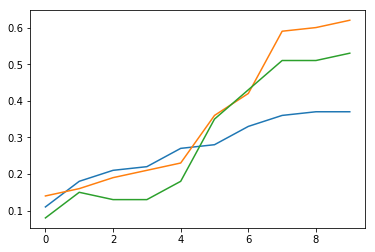

In [106]:
plt.plot(cnnI.fc_net.Accu)
plt.plot(cnnII.fc_net.Accu)
plt.plot(cnnIII.fc_net.Accu)

# Building Model
I study through some websites and articals about LeNet, and find out most suggest 2 fully-connected layers, 100 and 10; and 5* 5 kernel size. 

As for batch size and kernel number, after several experiment, I found the size of one batch and number of kernel will significantly affect time needed for trainging, more kernel will be more likely to provide a more precise outcome though.

However, I found that, after several experiment again : a two layers of Convolution , with 6 and 16 kernel each, and batch size of 200 can provide a accurate enough model by a acceptable trainging time, so I adapt them into my architecture.

Here is the code of building and training my model.

In [19]:
batch_size = 200
input_data_spec = [batch_size, 1, 28, 28]
conv_layer_spec = [{"k_num" : 6, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 16, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]

cnn2 = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)

epoch = 3 #number of epoch wanna train
learning_rate = 0.05
# for each epoch
for e in range(epoch):

    print("\n####### EPOCH ", e, "#######")
    ################
    #TRANING PHASE
    f2 = open("mnist_train_50000.csv", 'r')
    a = f2.readlines()
    f2.close()

    x = []
    y = []

    count = 0
    total_count = 0
    for line in a:

        linebits = line.split(',')
        x_line = [int(linebits[i]) for i in range(len(linebits))]
        x.append(x_line[1:])
        y.append(x_line[0])
        count += 1
        #start training whenever collect enough data to compose a batch
        if(count == batch_size):
            #I remove the tranpose of input in 6/8 original version 
            train_x = np.clip( np.array(x), 0, 1).reshape(batch_size , 1, 28, 28)
            train_y = np.array(y)
            cnn2.train(train_x, train_y, 1, learning_rate, e)
            if( np.isnan(cnn2.fc_net.J[-1]) ):
                print("NAN NAN NAN NAN NAN NAN")
                break;
            count = 0
            total_count += 1
            x = []
            y = []
    
    #make learning rate lower after each epoch, the chance must be slighter to be more precise
    #since the differences between my model and ground truth are getting smaller and smaller
    learning_rate /= 10
    #take mean of Accuracy after add up all accuracy of each batch
    cnn2.fc_net.Accu[e] /= total_count
            
            
    #############
    #VALIDATION PHASE
    #run validation after each epoch
    fv = open("mnist_validation_10000.csv", 'r')
    v = fv.readlines()
    fv.close()
    x = []
    y = []
    count = 0
    for line in v:
        linebits = line.split(',')
        x_line = [int(linebits[i]) for i in range(len(linebits))]
        x.append(x_line[1:])
        y.append(x_line[0])
        count += 1
        if(count == batch_size):
            train_x = np.clip( np.array(x), 0, 1).reshape(batch_size, 1, 28, 28)
            train_y = np.array(y)
            #run predict here so the model won't run backprop
            cnn2.predict(train_x, train_y,e)
            count = 0
            x = []
            y = []
    cnn2.fc_net.ValidJ[e] /= 50 # 10000/200 = 50
    cnn2.fc_net.VAccu[e] /= 50
   

'''
J of each batch is printed below, I run every batch for 1 iteration, that's way it's all iteration 
there are 250 batches in every epoch
'''


####### EPOCH  0 #######
Iteration  0 : 2.40598
Iteration  0 : 2.32141
Iteration  0 : 2.31510
Iteration  0 : 2.29276
Iteration  0 : 2.28098
Iteration  0 : 2.28082
Iteration  0 : 2.28568
Iteration  0 : 2.24555
Iteration  0 : 2.22516
Iteration  0 : 2.18465
Iteration  0 : 2.21735
Iteration  0 : 2.21035
Iteration  0 : 2.18189
Iteration  0 : 2.14079
Iteration  0 : 2.16676
Iteration  0 : 2.19602
Iteration  0 : 2.16857
Iteration  0 : 2.09396
Iteration  0 : 2.02451
Iteration  0 : 2.03285
Iteration  0 : 2.03342
Iteration  0 : 1.98379
Iteration  0 : 1.95543
Iteration  0 : 1.95272
Iteration  0 : 2.04469
Iteration  0 : 1.89957
Iteration  0 : 1.92022
Iteration  0 : 1.85580
Iteration  0 : 1.84825
Iteration  0 : 1.78938
Iteration  0 : 1.94825
Iteration  0 : 1.87472
Iteration  0 : 1.71194
Iteration  0 : 1.87274
Iteration  0 : 1.86387
Iteration  0 : 1.77650
Iteration  0 : 1.82837
Iteration  0 : 1.77767
Iteration  0 : 1.83271
Iteration  0 : 1.83677
Iteration  0 : 1.72564
Iteration  0 : 1.75026
Iteratio

# Time spent
runing 1 epoch will take around 10000 ~ 12500 seconds, which is around 3 hours
the whole training (of 3 epoch) spent around 8~9 hours

# Training data and Result

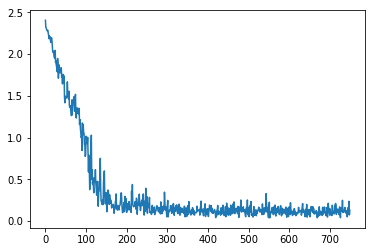

In [26]:
# Loss value of every batch, in 3 epoch
#note that 0~250 is fthe irst epoch, 251~500 is the second, and 501~750 is the third
plt.plot(cnn2.fc_net.J)

[0.7180200000000005, 0.9600200000000001, 0.9636200000000001]


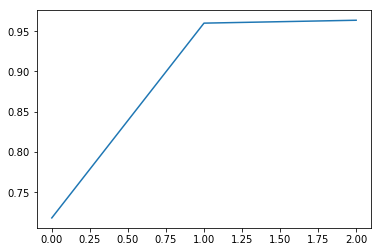

In [76]:
# average Accuracy of 3 epoch each
print(cnn2.fc_net.Accu)
plt.plot(cnn2.fc_net.Accu)

### note that the first data point is accuracy AFTER epoch 0, accuracy before any training shoud be around 0.1
we can see that the slope become much smaller as learning rate become smaller

[0.17842983285433336, 0.114169047714427, 0.11307766810440927]


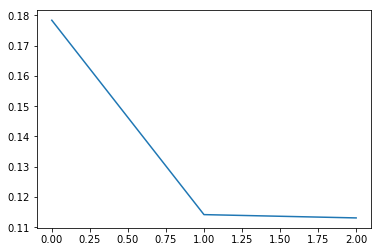

In [78]:
# Loss function of  validation data after each epoch
# note that before any training, the loss value shoud be 2.x
print(cnn2.fc_net.ValidJ)
plt.plot(cnn2.fc_net.ValidJ)

[0.9453000000000003, 0.9650000000000002, 0.9653999999999998]


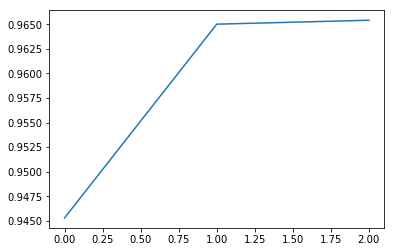

In [79]:
# Accuracy of  validation data after each epoch
print(cnn2.fc_net.VAccu)
plt.plot(cnn2.fc_net.VAccu)

accuracy of validaiton is slightly higher than of training data, because accuracy of training data is the average while training, but accuracy of validation is after training, which mean the model should be better.

# Testing
### final Accuracy of testing data : 96.55%

In [80]:
import time
TestAccuracy = []
ft = open("mnist_test_10000.csv", 'r')
t = ft.readlines()
ft.close()
x = []
y = []
count = 0
start = time.time()
for line in t:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])
    count += 1
    if(count == batch_size):
        train_x = np.clip( np.array(x), 0, 1).reshape(batch_size, 1, 28, 28)
        train_y = np.array(y)
        
        #rather than run predict(), I ren only forward() and accuracy() (so that I can decide witch array to pass into accuracy() )
        cnn2.forward(train_x)
        cnn2.fc_net.accuracy(train_y, TestAccuracy, 0)
        
        count = 0
        x = []
        y = []

Accuracy = TestAccuracy[0] / (10000/ batch_size)
print(" Time spent : ", time.time() - start)
print( " Accruacy of Testing dataset after model trained : ", Accuracy)        

#note that  "Time spent " only measure the time needed to predict all testing data

 Time spent :  669.9070026874542
 Accruacy of Testing dataset after model trained :  0.9654999999999998


# final Accuracy of testing data

In [67]:
Accuracy = TestAccuracy[0] / (10000/ batch_size)
print(Accuracy)

0.9654999999999998


## Above is the best version of model that I've get
below is the other result that i trained with different learning rate


### 3 epoch with learning rate : 0.01, 0.005, 0.0025
final accuracy of testing data is 95%

 LOSS VALUE of every batch in 3 epoch 


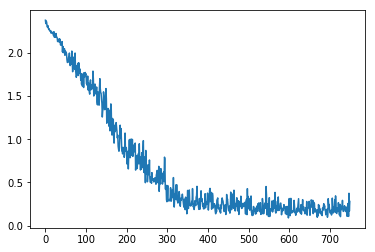

In [85]:
print( " LOSS VALUE of every batch in 3 epoch " )
plt.plot(J) 

Compare this diagram with the best version's, will find that the slope of J's decrease is much steeper there, due to higher learning rate

 LOSS VALUE of Validation after each epoch 


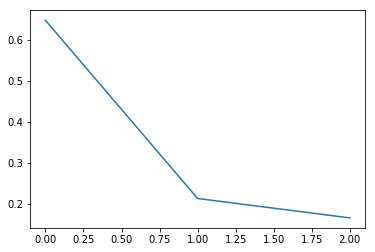

In [91]:
print( " LOSS VALUE of Validation after each epoch " )
plt.plot(VJ)

Accuracy of validation (orange), and training data(blue) 


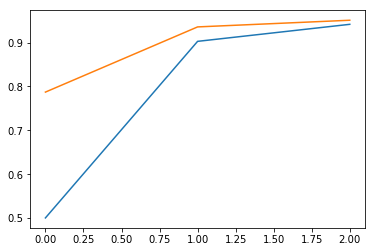

In [92]:
print( "Accuracy of validation (orange), and training data(blue) " )
plt.plot(accu)
plt.plot(Vaccu)